# Rossman Store Sales

This notebook explores sales forecasting for a retail store chain using historical transactional data. The aim is to predict daily sales for each store during a 6-week test period in 2015, using patterns learned from past data.

The approach involves data cleaning, feature engineering, and model training using XGBoost. After preprocessing, the model is trained to predict sales based on a range of store attributes, calendar features, and promotional indicators. Predictions are then validated, visualized, and compared against historical sales to assess performance and interpret model behavior.

In [95]:
import warnings
warnings.filterwarnings("ignore")

# loading packages
# basic + dates 
import pandas as pd
import numpy as np


# data visualization
import matplotlib.pyplot as plt
import seaborn as sns 
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')


# statistics
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.metrics import mean_squared_error

# time series analysis
import xgboost as xgb


In [96]:
# importing train data to learn
train = pd.read_csv("train.csv", 
                    parse_dates = True, low_memory = False, index_col = 'Date')

# additional store data
store = pd.read_csv("store.csv", 
                    low_memory = False)

# importing test data
test = pd.read_csv("test.csv", 
                    low_memory = False)

In [97]:
# first glance at the train set
print(train.shape)
train.head()

(1017209, 8)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [98]:
# data extraction
train['Year'] = train.index.year
train['Quarter'] = train.index.quarter
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.isocalendar().week
train['DayOfYear'] = train.index.dayofyear

# adding new variable
train['SalePerCustomer'] = train['Sales']/train['Customers']
train['SalePerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

In [99]:
# New updatatd train table
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Quarter,Month,Day,WeekOfYear,DayOfYear,SalePerCustomer
Date,,,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,3,7,31,31,212,9.482883
2015-07-31,2,5,6064,625,1,1,0,1,2015,3,7,31,31,212,9.702400
2015-07-31,3,5,8314,821,1,1,0,1,2015,3,7,31,31,212,10.126675
2015-07-31,4,5,13995,1498,1,1,0,1,2015,3,7,31,31,212,9.342457
2015-07-31,5,5,4822,559,1,1,0,1,2015,3,7,31,31,212,8.626118


### ECDF Analysis

Empirical Cumulative Distribution Functions (ECDFs) are used here to visualize how the three core daily metrics: Sales, Customers, and Sales per Customer, are distributed across the training set. These plots help reveal skewness, zero values, and rare high-value days, offering early clues about store behavior, demand patterns, and potential outliers. 

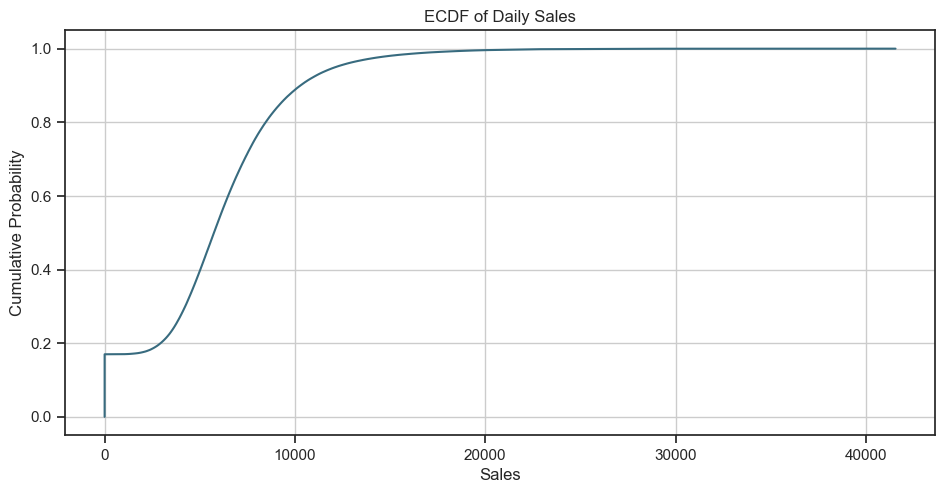

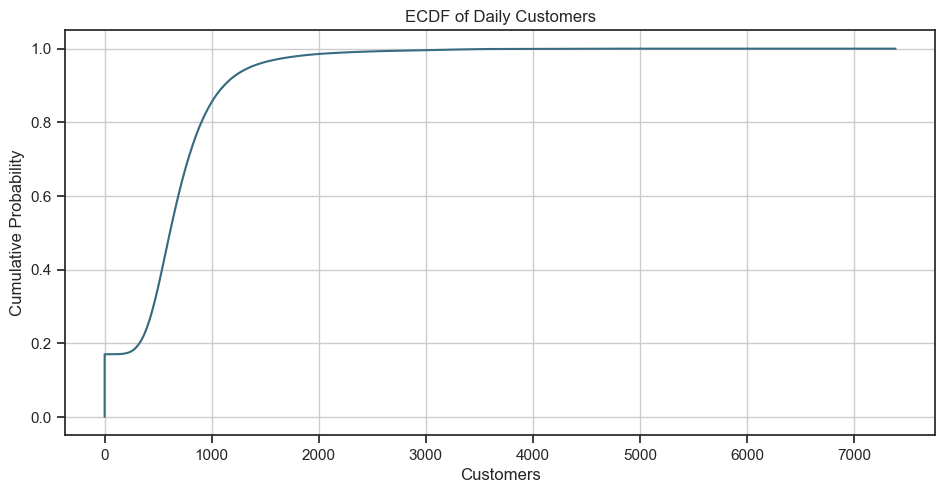

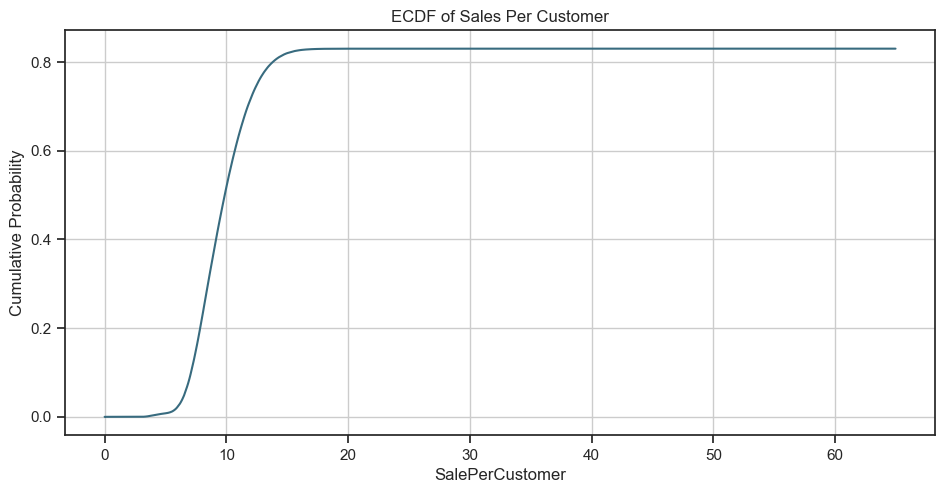

In [101]:
# Style
sns.set(style="ticks")
c = '#386B7F'

# ECDF for Sales
plt.figure(figsize=(10, 5))
cdf = ECDF(train['Sales'])

plt.plot(cdf.x, cdf.y, label="ECDF of Sales", color=c)
plt.xlabel('Sales')
plt.ylabel('Cumulative Probability')
plt.title('ECDF of Daily Sales')
plt.grid(True)
plt.show()


# ECDF for Sales
plt.figure(figsize=(10, 5))
cdf = ECDF(train['Customers'])

plt.plot(cdf.x, cdf.y, label="ECDF of Customers", color=c)
plt.xlabel('Customers')
plt.ylabel('Cumulative Probability')
plt.title('ECDF of Daily Customers')
plt.grid(True)
plt.show()

# ECDF for Sales
plt.figure(figsize=(10, 5))
cdf = ECDF(train['SalePerCustomer'])

plt.plot(cdf.x, cdf.y, label="ECDF of SalePerCustomer", color=c)
plt.xlabel('SalePerCustomer')
plt.ylabel('Cumulative Probability')
plt.title('ECDF of Sales Per Customer')
plt.grid(True)
plt.show()

The ECDF plots reveal that approximately 20% of the data shows zero daily sales or customers, likely indicating days when the store was closed, such as Sundays or public holidays. This is supported by the consistent flat segment at the beginning of both the sales and customer ECDFs.

Around 80% of daily sales fall below 10,000, and most stores serve fewer than 2,000 customers per day. Sales per customer are more tightly distributed, with the majority spending between 10 and 15 units, reflecting stable customer spending patterns.

These zero values are important to flag, as they can distort averages and impact model performance. While store closures are the most probable explanation, it is worth investigating other potential causes such as unmarked holidays, data entry issues, or operational outages. Thoughtfully filtering or flagging these entries could significantly enhance the accuracy of future forecasts and trend analyses.

### Cleaning

Here we will be taking a closer look at missing values in the data set and try understand where they come from.

In [105]:
# Identify closed stores
print(train[(train.Open == 0) & (train.Sales == 0)].shape)
closed_stores = train[(train.Open == 0) & (train.Sales == 0)]
closed_stores.head()


(172817, 15)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Quarter,Month,Day,WeekOfYear,DayOfYear,SalePerCustomer
Date,,,,,,,,,,,,,,,
2015-07-31,292,5,0,0,0,1,0,1,2015,3,7,31,31,212,NaN
2015-07-31,876,5,0,0,0,1,0,1,2015,3,7,31,31,212,NaN
2015-07-30,292,4,0,0,0,1,0,1,2015,3,7,30,31,211,NaN
2015-07-30,876,4,0,0,0,1,0,1,2015,3,7,30,31,211,NaN
2015-07-29,292,3,0,0,0,1,0,1,2015,3,7,29,31,210,NaN


Out of 1,017,209 total records, 172,817 correspond to days when the store was closed. These will be dropped to prevent the model from being biased by situations where sales couldn’t have occurred.

As for the cases where stores were open but still reported zero sales, these require a closer look. They could indicate unusual customer behavior, stock issues, or data inconsistencies. It’s important to assess whether to keep, impute, or exclude them based on their frequency and context.



In [107]:
# opened stores with zero sales CHANGE ORDER

zero_sales = train[(train.Open != 0) & (train.Sales == 0)]
zero_sales.head()
print(zero_sales.shape)

(54, 15)


There are a few instances where stores were open on regular working days but recorded no sales. Since this only happens on 54 days across the entire dataset, it’s likely due to external factors such as public demonstrations, school holidays, or other unexpected disruptions.


In [109]:
# Excluding stores that are closed and days with zero sales from the training data set
train = train[(train["Open"] != 0) & (train['Sales'] != 0)]
print(train.shape)

(844338, 15)


Closed stores and days with no recorded sales are excluded from the forecasts to ensure the model reflects genuine customer activity and avoids skewing predictions with non-operational data.

Now that we are done looking for zero values in the training data set, lets look for null values in the store data set, where they store information about stores.

- Store: a unique Id for each store
- StoreType: differentiates between 4 different store models: a, b, c, d
- Assortment: describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance: distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year]: gives the approximate year and month of the time the nearest competitor was opened
- Promo2: Promo2 is a continuing a promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week]: describes the year and calendar week when the store started participating in Promo2
- PromoInterval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store


In [112]:
# additional information about the stores
store

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [113]:
# Where is the bulk of the null values
print(store.isnull().sum())

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64


We identified a few variables with missing values that need to be addressed before modeling. Starting with **CompetitionDistance**, which has only three missing entries.

In [115]:
store[pd.isnull(store.CompetitionDistance)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


Apperently this information is simply missing from the data. No particular pattern observed. We can impute these using a reasonable strategy, such as filling them with the median or maximum value, to preserve the distribution while ensuring minimum information is lost due to nulls.


In [117]:
# Check skewness numerically
skewness = store['CompetitionDistance'].skew()
print("Skewness of CompetitionDistance:", skewness)


Skewness of CompetitionDistance: 2.9292856455312055


Given that the skewness of CompetitionDistance is **2.93**, which is significantly positive, this indicates that the data is right-skewed. In right-skewed distributions, the majority of values are concentrated on the left, with a few extreme values stretching out to the right.

Because the mean is sensitive to these extreme values, it could lead to distorted imputation if used. Instead, the **median** is a better choice for imputation, as it is not influenced by outliers and will provide a more robust estimate of the typical value in this skewed distribution. Therefore, for the missing values in CompetitionDistance, I will use the **median** to ensure the imputation is consistent with the overall data distribution.

In [119]:
# Impute missing values with median
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace=True) 

#### Handling Missing **Promo2SinceWeek** Values:

To ensure consistency in the dataset, we check the relationship between Promo2 and Promo2SinceWeek. If Promo2 is zero, it makes sense for Promo2SinceWeek to be missing. 

In [121]:
# Identify stores where 'Promo2SinceWeek' is missing
promo_missing = store[pd.isnull(store.Promo2SinceWeek)]

# Check how many of these missing values correspond to stores that have 'Promo2' as zero
promo_missing[promo_missing.Promo2 != 0].shape


(0, 10)

Since all missing values in **Promo2SinceWeek** occur only when **Promo2 = 0**, we can safely assume that these stores were not participating in the promotion. Replacing the NaNs with 0 is therefore both safe and meaningful, as it accurately reflects the absence of an ongoing promotion.

In [123]:
# Fill NaN values in 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'  with 0
store['Promo2SinceWeek'].fillna(0, inplace=True)
store['Promo2SinceYear'].fillna(0, inplace=True)
store['PromoInterval'].fillna(0, inplace=True)

#### Handling Missing **CompetitionOpenSinceMonth** and **CompetitionOpenSinceYear** Values:

In [125]:
# Identify rows where CompetitionOpenSinceMonth is missing
missing_comp_month = store[store['CompetitionOpenSinceMonth'].isnull()]

# From those, select only rows where CompetitionDistance is NOT zero
suspicious_rows = missing_comp_month[missing_comp_month['CompetitionDistance'] != 0]

# Display the result as a table
suspicious_rows


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,0.0,0.0,0
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1130.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,540.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9260.0,NaN,NaN,0,0.0,0.0,0
1113,1114,a,c,870.0,NaN,NaN,0,0.0,0.0,0


For **CompetitionOpenSinceMonth** and **CompetitionOpenSinceYear**, we observe that all 354 missing values occur only in rows where **CompetitionDistance** is non-zero. This suggests that while a competitor exists, the specific opening date wasn't recorded. Since the presence of competition is acknowledged but the timing is unknown, we can either choose to remove these rows or impute the missing dates, depending on how much we want to preserve the data versus maintain date accuracy.


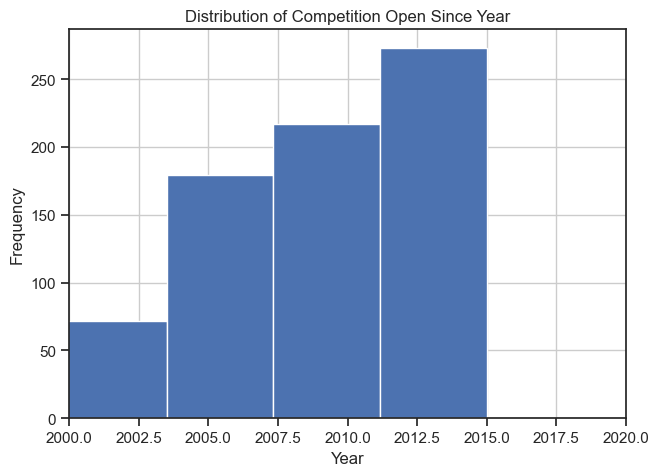

In [127]:
# Checking to impute with mean or median.
store['CompetitionOpenSinceYear'].hist(bins=30)
plt.xlim(2000, 2020)  # zooms in on this range — adjust as needed
plt.title('Distribution of Competition Open Since Year')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

In [128]:
skewness = store['CompetitionOpenSinceYear'].skew()
print("Skewness of CompetitionOpenSinceYear:", skewness)

Skewness of CompetitionOpenSinceYear: -8.013061944431684


Given the strong left skew in **CompetitionOpenSinceYear** (skewness = -8.01), and based on the histogram showing that most values cluster toward more recent years, imputing with the **median** is the most appropriate choice. This avoids distortion from extreme early-year values and better represents the typical timeframe when competition began.

In [130]:
# Impute missing values with median
store['CompetitionOpenSinceYear'].fillna(store['CompetitionOpenSinceYear'].median(), inplace=True) 
store['CompetitionOpenSinceMonth'].fillna(store['CompetitionOpenSinceMonth'].median(), inplace=True) 

In [131]:
# Ensure there are no more null values
print(store.isnull().sum())

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64


In [132]:
# Joining train set with an additional store information

# Inner join to merge train and store datasets based on 'Store' column
train_store = pd.merge(train, store, how='inner', on='Store')

train_store

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Quarter,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,3,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,6064,625,1,1,0,1,2015,3,...,9.702400,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,8314,821,1,1,0,1,2015,3,...,10.126675,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,13995,1498,1,1,0,1,2015,3,...,9.342457,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,5,4822,559,1,1,0,1,2015,3,...,8.626118,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844333,682,2,3375,566,1,0,a,1,2013,1,...,5.962898,b,a,150.0,9.0,2006.0,0,0.0,0.0,0
844334,733,2,10765,2377,1,0,a,1,2013,1,...,4.528818,b,b,860.0,10.0,1999.0,0,0.0,0.0,0
844335,769,2,5035,1248,1,0,a,1,2013,1,...,4.034455,b,b,840.0,8.0,2010.0,1,48.0,2012.0,"Jan,Apr,Jul,Oct"
844336,948,2,4491,1039,1,0,a,1,2013,1,...,4.322425,b,b,1430.0,8.0,2010.0,0,0.0,0.0,0


## Time Series Modeling with XGBoost

In this section, we focus on forecasting store sales using historical data and time-based patterns. To do this, we employ **XGBoost**, a gradient boosted decision tree algorithm known for its speed and performance on structured data.

The approach involves treating this forecasting task as a **supervised learning problem**, where past sales and engineered time features (such as day of the week, month, promo status, and competition timing) are used to predict future sales.
Before training the model, we engineer relevant features from the date and store metadata. This allows the model to capture important seasonality patterns, promotional effects, and competitive pressure.
After fitting the model, we examine **feature importance** to understand which variables contributed most to predictions. This not only helps validate our assumptions but also provides business insight—highlighting whether promotions, holidays, or competition drive store performance the most.
This method bridges classic time series forecasting with modern machine learning, offering flexibility in incorporating categorical and time based variables while maintaining predictive power.


In [135]:
from sklearn.preprocessing import LabelEncoder

# Encode categorical features as integers for model compatibility
label_cols = ['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval']
for col in label_cols:
    train_store[col] = train_store[col].astype(str)  # Ensure consistent string type
    le = LabelEncoder()
    train_store[col] = le.fit_transform(train_store[col])


In [136]:
from sklearn.model_selection import train_test_split

# Prepare training features and target, removing target and leaky columns
X_train = train_store.drop(columns=['Sales', 'Customers', 'SalePerCustomer'])
y_train = train_store['Sales']

# Split into training and validation sets (80/20 split)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, shuffle=True)


In [137]:
import xgboost as xgb

# Build and train the XGBoost regression model with early stopping
reg = xgb.XGBRegressor(
    n_estimators=5000,
    early_stopping_rounds=50,
    objective='reg:squarederror',  # for regression tasks
    max_depth=6,
    learning_rate=0.08,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Fit the model and monitor performance on training and validation sets
reg.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    verbose=100
)

[0]	validation_0-rmse:3032.50819	validation_1-rmse:3035.85891
[100]	validation_0-rmse:1871.14801	validation_1-rmse:1874.23883
[200]	validation_0-rmse:1459.54362	validation_1-rmse:1462.62965
[300]	validation_0-rmse:1237.82164	validation_1-rmse:1241.49956
[400]	validation_0-rmse:1116.11505	validation_1-rmse:1120.90251
[500]	validation_0-rmse:1036.52005	validation_1-rmse:1042.77951
[600]	validation_0-rmse:978.78405	validation_1-rmse:986.45355
[700]	validation_0-rmse:938.77996	validation_1-rmse:947.78746
[800]	validation_0-rmse:908.95549	validation_1-rmse:919.80124
[900]	validation_0-rmse:883.57308	validation_1-rmse:895.89491
[1000]	validation_0-rmse:861.95945	validation_1-rmse:875.99805
[1100]	validation_0-rmse:842.72784	validation_1-rmse:857.97534
[1200]	validation_0-rmse:825.91518	validation_1-rmse:842.73426
[1300]	validation_0-rmse:812.77432	validation_1-rmse:831.05022
[1400]	validation_0-rmse:798.92435	validation_1-rmse:818.68750
[1500]	validation_0-rmse:785.81214	validation_1-rmse:80

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.08, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=5000,
             n_jobs=None, num_parallel_tree=None, ...)

The learning curve shows steadily decreasing RMSE on both training and validation sets, with the validation curve closely tracking the training curve. This pattern suggests the model is learning effectively without overfitting. The final early stopping point is marked with a dashed line, confirming that performance on unseen data plateaued—an ideal outcome in time series modeling.

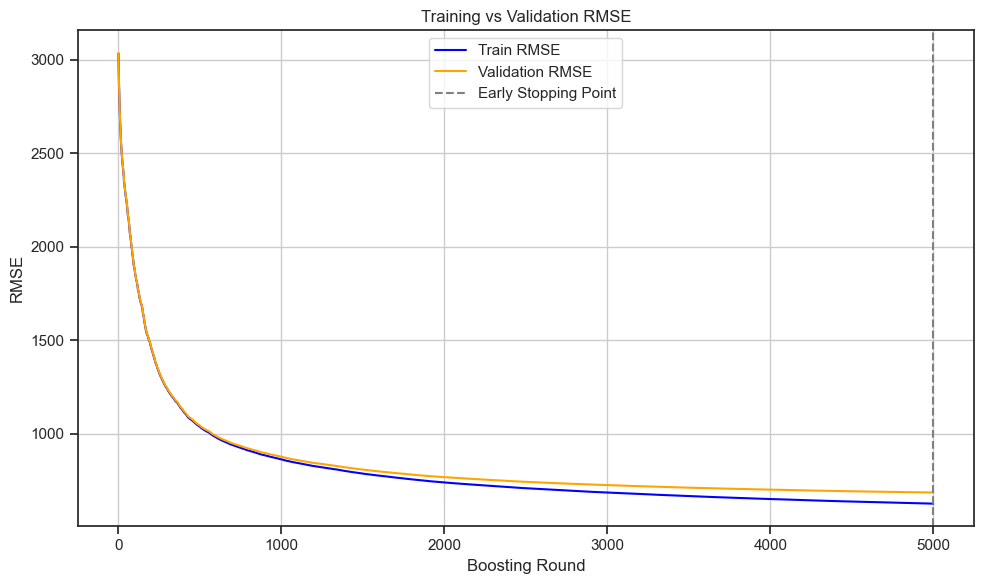

In [139]:
# Grabbing the error results to plot
evals_result = reg.evals_result()

# Plot learning curve
train_errors = evals_result['validation_0']['rmse']
valid_errors = evals_result['validation_1']['rmse']

plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train RMSE', color='blue')
plt.plot(valid_errors, label='Validation RMSE', color='orange')
plt.axvline(len(valid_errors)-1, linestyle='--', color='gray', label='Early Stopping Point')
plt.xlabel('Boosting Round')
plt.ylabel('RMSE')
plt.title('Training vs Validation RMSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


After 5000 boosting rounds, the XGBoost model achieved a root mean squared error (RMSE) of approximately **625** on the training set and **685** on the validation set. The small gap between the two indicates good generalization, with no major signs of overfitting. Since sales are measured in units of currency, this means the model’s average prediction error is around **685 monetary units**, which is a strong performance given the variability in daily sales.

### Feature Importance

This horizontal bar chart shows the relative importance of each feature in predicting daily sales, based on XGBoost's gain metric — which reflects how much each feature contributed to reducing the model's error. Features with higher gain values had a more meaningful impact on model performance.

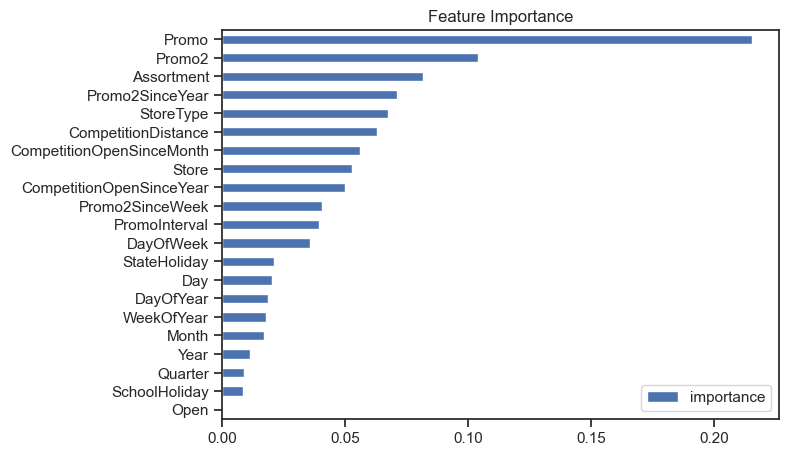

In [142]:
#Feature importance
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

Promo stands out as the most influential feature, with a gain score around 0.215. This confirms that active promotions have a major impact on sales volume, highlighting their role as a key business driver.

StoreType and Assortment (both ~0.08 gain) also rank high, showing that store-specific configurations significantly influence performance. The model likely captures systematic differences across store formats—such as flagship vs. convenience stores—which suggests that segmenting stores or tailoring strategies could be beneficial.

Promo2SinceYear, Promo2SinceWeek, and PromoInterval (~0.07–0.10 gain) are also important. These reflect the impact of long-term promotional exposure. The model not only considers whether a store is running a promotion, but also how long it has been doing so. This suggests time-based features like "days since promo started" could further strengthen performance.

CompetitionDistance (~0.062 gain) and CompetitionOpenSinceMonth and Year (~0.049 / ~0.056 gain) fall in the mid-range of importance. These features imply that nearby competition and its maturity do affect store sales, but not as powerfully as promotional efforts or store identity. They reflect the economic pressure of market saturation.

Finally, SchoolHoliday and StateHoliday (~0.008–0.02 gain) show lower importance. This could mean holidays don’t significantly affect most stores, or that their effects are already captured through other time-based features like month or day of year. It may be worth refining these variables—for example, by distinguishing national vs. local holidays or exploring interactions like promotions during holidays.

## Forecasting sales

Using the trained model, we forecast sales across all stores in the test set for the 6 week period from **2015-08-01 to 2015-09-17**. This allows us to simulate expected performance based on historical patterns and the engineered features, providing a foundation for business planning, inventory management, and evaluating promotional strategies.


In [146]:
# Data extraction
test['Date'] = pd.to_datetime(test['Date'])
test['Year'] = test['Date'].dt.year
test['Quarter'] = test['Date'].dt.quarter
test['Month'] = test['Date'].dt.month
test['Day'] = test['Date'].dt.day
test['WeekOfYear'] = test['Date'].dt.isocalendar().week.astype(int)
test['DayOfYear'] = test['Date'].dt.dayofyear

# Inner join to merge test and store datasets based on 'Store' column
test_store = pd.merge(test, store, how='inner', on='Store')

# Encode non- numerical data
label_cols = ['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval']
for col in label_cols:
    test_store[col] = test_store[col].astype(str)  # Just in case
    le = LabelEncoder()
    test_store[col] = le.fit_transform(test_store[col])

In [147]:
# Make sure test data has the right columns
X_test = test_store[reg.feature_names_in_]

# Predict sales with trained model
y_pred = reg.predict(X_test)

# Adjust table display
test_store['PredictedSales'] = y_pred
test['PredictedSales'] = y_pred.round().astype(int)

test_display = test.drop(columns=['Year', 'Quarter', 'Month', 'Day', 'WeekOfYear', 'DayOfYear']) 
test_display

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,PredictedSales
0,1,1,4,2015-09-17,1.0,1,0,0,4360
1,2,3,4,2015-09-17,1.0,1,0,0,7444
2,3,7,4,2015-09-17,1.0,1,0,0,9548
3,4,8,4,2015-09-17,1.0,1,0,0,7250
4,5,9,4,2015-09-17,1.0,1,0,0,7110
...,...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0,2403
41084,41085,1112,6,2015-08-01,1.0,0,0,0,7601
41085,41086,1113,6,2015-08-01,1.0,0,0,0,6225
41086,41087,1114,6,2015-08-01,1.0,0,0,0,23242


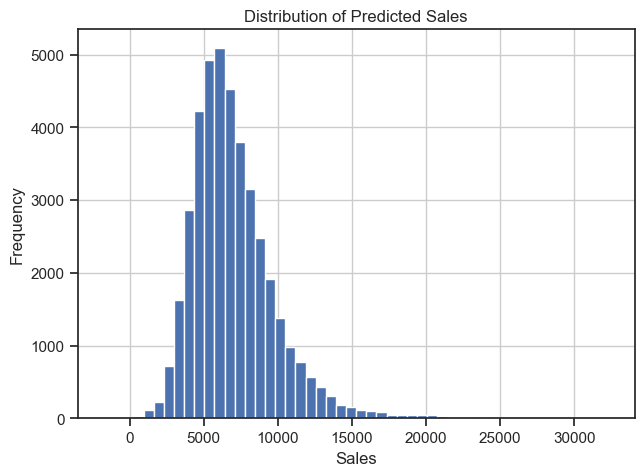

In [148]:
pd.Series(y_pred).hist(bins=50)
plt.title("Distribution of Predicted Sales")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.show()

## Store Evaluation

To evaluate the quality of our model’s predictions, we take a closer look at Store 42 by comparing its predicted sales for the 6-week test period in 2015 with its actual sales during the same calendar period in 2014. By shifting last year’s data forward by one year, we align the dates and visualize how closely the predicted sales track with historical performance. This year-over-year approach helps us understand whether the model has captured seasonal trends, promotional effects, and overall store behavior—especially important for validating that the model isn’t just producing plausible numbers, but contextually relevant ones. 

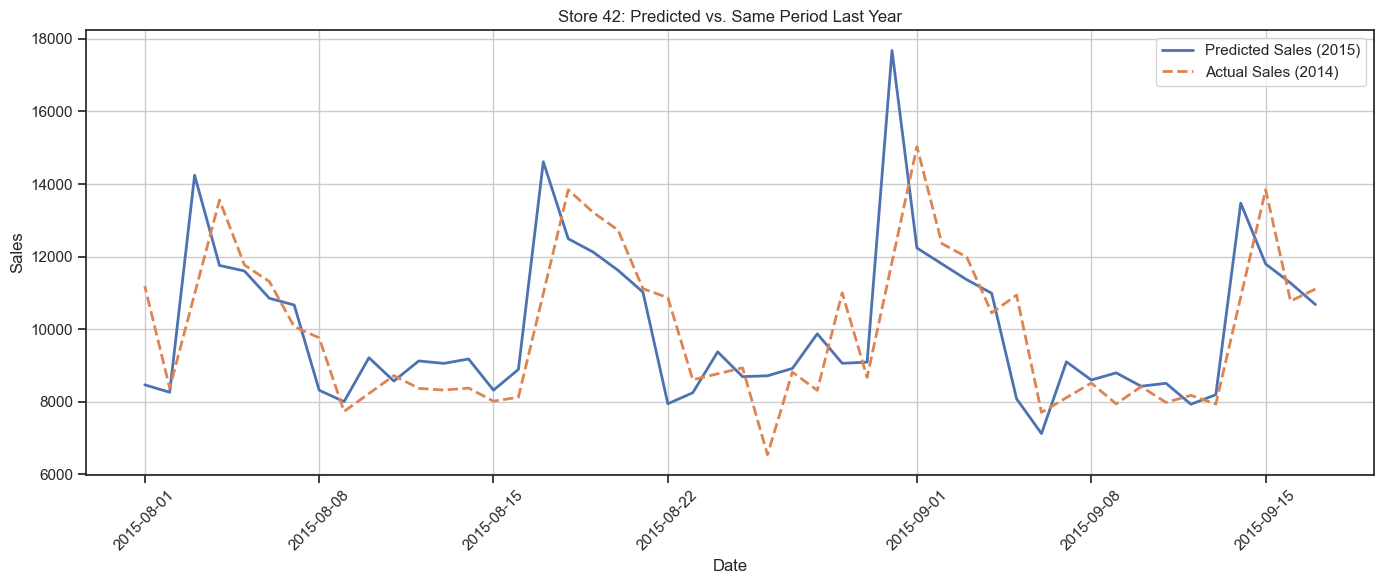

In [151]:

# Choose a store 
store_id = 42

# Preparing predicted sales for this store 
store_test = test_store[test_store['Store'] == store_id].copy()
store_test['Sales_Predicted'] = y_pred[test_store['Store'] == store_id]
store_test['Date'] = pd.to_datetime(store_test['Date'])
store_test = store_test.sort_values('Date')

# Reconstruct 'Date' in train_store
train_store['Date'] = pd.to_datetime(train_store[['Year', 'Month', 'Day']])

# Select historical period: same 6 weeks last year
start_date = pd.to_datetime('2014-08-01')
end_date = pd.to_datetime('2014-09-17')

store_past = train_store[
    (train_store['Store'] == store_id) & 
    (train_store['Date'] >= start_date) & 
    (train_store['Date'] <= end_date)
].copy()

# Shift historical dates forward by 1 year for side-by-side comparison
store_past['Date'] = store_past['Date'] + pd.DateOffset(years=1)

# Plot comparison
plt.figure(figsize=(14, 6))
plt.plot(store_test['Date'], store_test['Sales_Predicted'], label='Predicted Sales (2015)', linewidth=2)
plt.plot(store_past['Date'], store_past['Sales'], label='Actual Sales (2014)', linestyle='--', linewidth=2)

plt.title(f"Store {store_id}: Predicted vs. Same Period Last Year")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In this plot, we compare Store 42’s predicted sales for the 6-week 2015 test period against its actual sales from the same calendar window in 2014. The dates from the previous year were shifted forward to align both series. What we see is encouraging: the general rhythm of peaks and dips in sales mostly align, with only a slight offset of a day or two—which is expected, as we're not forecasting exact repetitions but patterns. 
One notable anomaly occurs on August 31, 2015, where predicted sales spike close to 18,000. While this seems like a major outlier, it's interesting to note that a similar spike happened on September 1 the year before. This suggests that the model may be capturing some real seasonal or promotional behavior, even if the exact timing isn't perfect—which is totally reasonable in this kind of forecasting.

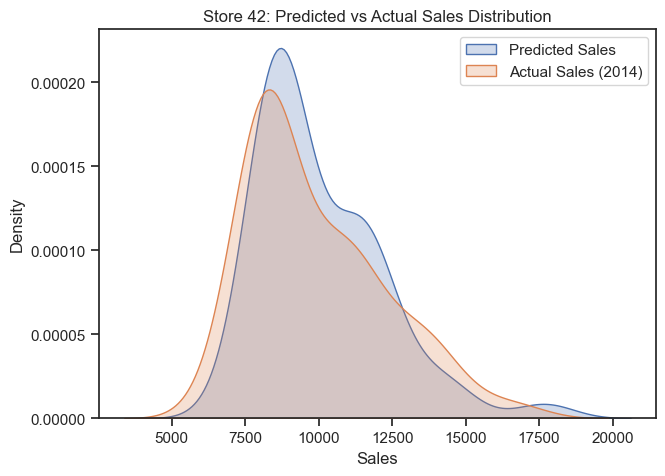

In [153]:
# Actual Sales from last year — no need to worry about shifted date
store_past_sales = train_store[
    (train_store['Store'] == store_id) & 
    (train_store['Year'] == 2014) &
    (train_store['Month'] >= 8) & 
    (train_store['Month'] <= 9)
]['Sales']

sns.kdeplot(y_pred[test_store['Store'] == store_id], label='Predicted Sales', shade=True)
sns.kdeplot(store_past_sales, label='Actual Sales (2014)', shade=True)
plt.title(f"Store {store_id}: Predicted vs Actual Sales Distribution")
plt.xlabel("Sales")
plt.ylabel("Density")
plt.legend()
plt.show()


This plot compares the distribution of predicted sales (for the 6-week forecast period in 2015) with actual sales from the same 6-week period in 2014 for Store 42. The two curves show a notably similar shape, with both peaking in the same general sales range and tapering off at similar points. This suggests that the model has learned the underlying sales pattern of this store fairly well, capturing both central tendencies and spread. The alignment reinforces that the model is capable of producing realistic forecasts, especially for this particular store's behavior year-over-year. 